## zarr persistent storage creation

### saving single array to disk

**REMEMBER** `chunks` is the **SIZE** of chunks, not number of chunks.

In [1]:
import os 
dirs_to_clear = ('single_array.zarr',
                 'arrays_in_group.zarr', 
                 'image_pyramid_example.zarr')
for dirname in dirs_to_clear:
    if os.path.isdir(dirname):
        import shutil
        shutil.rmtree(dirname)

In [2]:
import zarr 
z1 = zarr.open('single_array.zarr', mode='w', shape=(10000, 10000),
               chunks=(1000, 1000), dtype='i4')
z1[:]=1

In [3]:
z1.info

Type,zarr.core.Array
Data type,int32
Shape,"(10000, 10000)"
Chunk shape,"(1000, 1000)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,400000000 (381.5M)
No. bytes stored,1614845 (1.5M)
Storage ratio,247.7


### saving multiple arrays within a single dataset

In [4]:
root = zarr.group('arrays_in_group.zarr')
root

<zarr.hierarchy.Group '/'>

In [5]:
z1 = root.zeros('z1', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')
z1

<zarr.core.Array '/z1' (10000, 10000) int32>

In [6]:
z1.info

Name,/z1
Type,zarr.core.Array
Data type,int32
Shape,"(10000, 10000)"
Chunk shape,"(1000, 1000)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,400000000 (381.5M)
No. bytes stored,345


In [7]:
z2 = root.zeros('z2', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')

In [8]:
import os 

In [9]:
os.listdir('arrays_in_group.zarr')

['z2', '.zgroup', 'z1']

In [10]:
root['z1'], root['z2']

(<zarr.core.Array '/z1' (10000, 10000) int32>,
 <zarr.core.Array '/z2' (10000, 10000) int32>)

### creating a napari-ready image pyramid 

remember: with image pyramids, level 0 is highest resolution

In [11]:
im_pyr = zarr.group('image_pyramid_example.zarr')

In [12]:
z1 = im_pyr.create_group('z1')

In [13]:
2**15

32768

going to decrease both number of pixels by 2 per level by applying a diffusion operator. It's 2d, so not going to worry about operating by-chunk for the high-res level. 

In [14]:
import numpy  as np


def get_nchunks(shape, chunk_sizes):
    return tuple(np.ceil(np.asarray(shape) / np.asarray(chunk_sizes)).astype(int))

max_levels = 6
shape=(2**15, 2**15)

# max_levels = 4
# shape=(2**13, 2**13)

chunk_size=(2**9, 2**9)
n_chunks = get_nchunks(shape, chunk_size)

print("creating high resolution image")
id0_range = np.arange(shape[0])
id1_range = np.arange(shape[1])
ids = np.meshgrid(id0_range,id1_range)
vals = np.zeros(shape, dtype=np.float64)   # initialize high resolution value
vals[:shape[0]//2,:] = 2.0 # add a sharp boundary 

def add_peak(vals, ids, center_x, center_y, d, peak_val):
    centerx_id = center_x * ids[0].shape[0]
    centery_id = center_y * ids[0].shape[1]    
    d_val = d * ids[0].shape[0]    
    vals += peak_val * np.exp(-((ids[0] - centerx_id)/d_val)**2) * np.exp(-((ids[1] - centery_id)/d_val)**2)
    return vals


    
vals = add_peak(vals, ids, .1, .25, .1, 10)
vals = add_peak(vals, ids, .5, .5, .4, 8)
vals = add_peak(vals, ids, .75, .9, .05, 10)

for lev in range(max_levels+1):
    print(f"creating level {lev} with resolution {shape} and n_chunks {n_chunks}")
        
    lev_array = z1.empty(str(lev), shape=shape, chunks=chunk_size, dtype=np.float64)    
    lev_array[:] = vals[:]
    
    shape = (shape[0]//2, shape[1]//2)
    n_chunks = get_nchunks(shape, chunk_size)

    # update the image values by averaging adjacent 4 pixels
    newvals = np.zeros(shape)
    id0_range = np.arange(shape[0]) * 2
    id1_range = np.arange(shape[1]) * 2
    ids = np.meshgrid(id0_range,id1_range)
    newvals[:,:] = newvals[:,:] + vals[ids[1], ids[0]]
    newvals[:,:] = newvals[:,:] + vals[ids[1]+1, ids[0]]
    newvals[:,:] = newvals[:,:] + vals[ids[1], ids[0]+1]
    newvals[:,:] = newvals[:,:] + vals[ids[1]+1, ids[0]+1]
    newvals[:,:] = newvals/5.0 # under-weight so we see more change between level    
    vals = newvals

creating high resolution image
creating level 0 with resolution (32768, 32768) and n_chunks (64, 64)
creating level 1 with resolution (16384, 16384) and n_chunks (32, 32)
creating level 2 with resolution (8192, 8192) and n_chunks (16, 16)
creating level 3 with resolution (4096, 4096) and n_chunks (8, 8)
creating level 4 with resolution (2048, 2048) and n_chunks (4, 4)
creating level 5 with resolution (1024, 1024) and n_chunks (2, 2)
creating level 6 with resolution (512, 512) and n_chunks (1, 1)


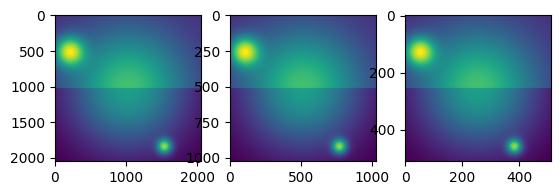

In [15]:
import matplotlib.pyplot as plt 

f, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(im_pyr['z1']['4'])
axs[1].imshow(im_pyr['z1']['5'])
axs[2].imshow(im_pyr['z1']['6'])

In [16]:
os.listdir('image_pyramid_example.zarr/z1')

['.zgroup', '0', '6', '1', '4', '3', '2', '5']

chunks are now stored individually by resolution level:

In [17]:
os.listdir('image_pyramid_example.zarr/z1/3')[:10]

['7.5', '7.2', '5.6', '.zarray', '5.1', '3.3', '3.4', '1.0', '1.7', '5.0']

In [18]:
z1['0'].info

Name,/z1/0
Type,zarr.core.Array
Data type,float64
Shape,"(32768, 32768)"
Chunk shape,"(512, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8589934592 (8.0G)
No. bytes stored,5273402197 (4.9G)


In [19]:
z1['3'].info

Name,/z1/3
Type,zarr.core.Array
Data type,float64
Shape,"(4096, 4096)"
Chunk shape,"(512, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,134217728 (128.0M)
No. bytes stored,92882233 (88.6M)


In [20]:
z1['4'].info

Name,/z1/4
Type,zarr.core.Array
Data type,float64
Shape,"(2048, 2048)"
Chunk shape,"(512, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,33554432 (32.0M)
No. bytes stored,24355842 (23.2M)


In [21]:
import napari

In [22]:
v = napari.Viewer()

In [23]:
im_to_add = [im_pyr['z1'][str(lev)] for lev in range(max_levels+1)]
im_to_add

[<zarr.core.Array '/z1/0' (32768, 32768) float64>,
 <zarr.core.Array '/z1/1' (16384, 16384) float64>,
 <zarr.core.Array '/z1/2' (8192, 8192) float64>,
 <zarr.core.Array '/z1/3' (4096, 4096) float64>,
 <zarr.core.Array '/z1/4' (2048, 2048) float64>,
 <zarr.core.Array '/z1/5' (1024, 1024) float64>,
 <zarr.core.Array '/z1/6' (512, 512) float64>]

In [24]:
v.add_image(im_to_add, multiscale=True, contrast_limits=(0,10), colormap='viridis')

<Image layer 'im_to_add' at 0x4170cca00>